**Introduction**

To assess how well the posterior model probabilities are calibrated—that is, whether they truly correspond to the frequency with which each model is correct—we construct a calibration plot. For each run, we record the posterior probability assigned to the each model. We then partition the interval [0,1] of predicted probabilities into a set of bins. For each bin, we compute two quantities: (i) the total number of runs whose predicted probability falls into that bin, and (ii) the number of those runs where the true model was indeed correct. The empirical frequency in each bin is given by the ratio of these two counts. Plotting this empirical frequency against the bin center value yields the calibration curve, while the diagonal line y = x corresponds to perfect calibration. Deviations from the diagonal indicate systematic problem in the posterior model probabilities (e.g. not enough live points in the sampler settings). To quantify statistical uncertainty in each bin, we treat the number of correct outcomes as a binomial random variable, using its variance to construct error bars or confidence intervals. This procedure provides a clear diagnostic of whether the reported posterior model probabilities match their empirical frequencies.

In [1]:
import tbilby, bilby
import numpy as np
import matplotlib.pyplot as plt
import corner
import random
from scipy.stats import norm

Define the tbilby special prior

In [2]:
# to define Transdimensional Conditional prior you need to inherit from the relevant prior
class TransdimensionalConditionalUniform(tbilby.core.prior.TransdimensionalConditionalUniform):
   # one must define the transdimensional_condition_function function, so we know what to do with conditional variables...  
    # it is an abstract function; without it you can't instantiate this class 
    def transdimensional_condition_function(self,**required_variables):
        ''' setting the minimum according to the last peak value of the gaussian.
        # note that this class is not general in any sense, here you refer to the parameters you are 
        working with '''
        # mu is returned as an array 
        
        minimum = self.minimum
        maximum = 100        
        if(len(self.mu)>0): # handle the first mu case
            minimum = self.mu[-1]   
            maximum = 100*np.ones(self.mu[-1].shape)
            
            if isinstance(minimum, float):
                if len(self.mu) >= self.n_gauss:
                    minimum=-100
                    maximum=0
            else:                
                minimum[len(self.mu) >= self.n_gauss]=-100
                maximum[len(self.mu) >= self.n_gauss]=0
                                          
        return dict(minimum=minimum,maximum=maximum)
 

define the rest of the needed functions and priors 

In [5]:
# model 
n_peaks = 4
sigma = 10
Amp_noise = 0.05
def gauss(x,mu,sigma_g):
    return norm(mu,sigma_g).pdf(x)
# here we define a model which could be a sum of several functions.. 
component_functions_dict = {}
component_functions_dict[gauss] = (n_peaks,'mu')
model = tbilby.core.base.create_transdimensional_model('model',  component_functions_dict,\
                                                       returns_polarization=False,SaveTofile=True)


# priors 
priors_t = bilby.core.prior.dict.ConditionalPriorDict()
priors_t['n_gauss'] = tbilby.core.prior.DiscreteUniform(1,n_peaks,'n_gauss')
priors_t['sigma_g'] = sigma # set constant so we don't sample it 
# creates a list of conditional uniform priors, nested_conditional_transdimensional_params is used, 
# meaning you will get dependence mu2(mu1,mu0).. 
priors_t = tbilby.core.base.create_transdimensional_priors(transdimensional_prior_class=TransdimensionalConditionalUniform,\
                                                          param_name='mu',\
                                                          nmax= n_peaks,\
                                                          nested_conditional_transdimensional_params=['mu'],\
                                                          conditional_transdimensional_params=[],\
                                                          conditional_params=['n_gauss'],\
                                                          prior_dict_to_add=priors_t,\
                                                          SaveConditionFunctionsToFile=True,\
                                                          minimum= 0,maximum=100)

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'np', 'pd', 'infer_parameters_from_function', 'bilby', 'DiscreteUniform', 'create_transdimensional_priors', '_create_priors_with_nested_condition_functions', 'create_transdimensional_model', 'create_plain_priors', 'extract_maximal_likelihood_param_values', '_fix_posterior_if_needed', 'preprocess_results', '_recluster_one_dim_posterior_experimental_use_it_wisely', '_group_params_by_numerical_ending', 'gauss'])
creating file model.py. This file will not work as a standalone, you should use it as a referance and minor modifications, if requiered 


In [3]:
# define the needed things to carry out the analysis
calibration_plot_bins = np.linspace(0.0, 1.0, 11)  # 10 bins: [0,0.1),[0.1,0.2),...,[0.9,1.0]
B = len(calibration_plot_bins) - 1
total_entries = np.zeros(B, dtype=int)
correct_model = np.zeros(B, dtype=int)

Run the analysis: check that the stated probability means what we say it means  

In [6]:
x = np.linspace(0,100,1001)
num_runs = 100
amp_noise=0.15
for run in range(num_runs):
    rng = np.random.default_rng(run)

    # --- Draw true data (same as your approach) ---
    n_true = rng.integers(1, n_peaks + 1)   # true number of Gaussians
    print(f"n = {n_true}")
    mus_true = rng.choice(np.linspace(10, 90, 20), size=n_true, replace=False)

    y = np.sum([gauss(x, mu, sigma) for mu in mus_true], axis=0)
    y += norm(loc=0, scale=amp_noise).rvs(len(x), random_state=rng)

    # --- Fit / sample ---
    likelihood = bilby.likelihood.GaussianLikelihood(
        x, y, model, sigma=amp_noise * np.ones(len(x))
    )

    result = bilby.core.sampler.run_sampler(
        likelihood,
        priors=priors_t,
        sampler="dynesty",
        label="calibration_example",
        clean=True,
        nlive=20, # this is too little, just to save time
        outdir="outdir",
    )

    n_vals = np.rint(result.posterior['n_gauss'].to_numpy()).astype(int)
    n_vals = np.clip(n_vals, 1, n_peaks)

    # histogram over models {1,...,n_peaks} -> posterior mass per model
    hs, _ = np.histogram(n_vals, bins=np.arange(1, n_peaks + 2))
    hs = hs / hs.sum()

    # --- one-vs-all calibration: bin every model's probability with label 0/1 ---
    for m_idx in range(n_peaks):                 # m_idx = 0..n_peaks-1 corresponds to model m = m_idx+1
        p_m = hs[m_idx]
        y_m = 1 if (m_idx + 1) == n_true else 0  # true model indicator

        # bin p_m safely
        idx = np.digitize(p_m, calibration_plot_bins, right=True) - 1
        idx = np.clip(idx, 0, B - 1)

        total_entries[idx] += 1
        correct_model[idx] += y_m


23:12 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'


n = 4


23:12 bilby INFO    : Analysis priors:
23:12 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:12 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:12 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:12 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

216it [00:15,  9.51it/s, bound:16 nc: 65 ncall:1.0e+04 eff:2.1% logz=492.04+/-0.58 dlogz:0.105>0.1]

23:13 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


217it [00:17, 12.66it/s, bound:16 nc:  1 ncall:1.1e+04 eff:2.3% logz=492.13+/-0.58 dlogz:0.00455>0.1]

23:13 bilby INFO    : Rejection sampling nested samples to obtain 50 posterior samples
23:13 bilby INFO    : Sampling time: 0:00:17.063087


23:13 bilby INFO    : Summary of results:
nsamples: 50
ln_noise_evidence:    nan
ln_evidence: 492.125 +/-  0.637
ln_bayes_factor:    nan +/-  0.637

23:13 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'


n = 2


23:13 bilby INFO    : Analysis priors:
23:13 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:13 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:13 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:13 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

104it [00:02, 47.10it/s, bound:4 nc: 20 ncall:2.5e+03 eff:4.1% logz=490.22+/-0.34 dlogz:0.135>0.1]

23:13 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


109it [00:03, 29.14it/s, bound:4 nc:  1 ncall:2.7e+03 eff:4.9% logz=490.34+/-0.33 dlogz:0.00451>0.1]

23:13 bilby INFO    : Rejection sampling nested samples to obtain 48 posterior samples
23:13 bilby INFO    : Sampling time: 0:00:03.706011
23:13 bilby INFO    : Summary of results:
nsamples: 48
ln_noise_evidence:    nan
ln_evidence: 490.342 +/-  0.375
ln_bayes_factor:    nan +/-  0.375

23:13 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:13 bilby INFO    : Analysis priors:
23:13 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:13 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:13 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:13 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

189it [00:12,  9.31it/s, bound:12 nc: 74 ncall:8.0e+03 eff:2.3% logz=459.17+/-0.53 dlogz:0.206>0.1]

23:13 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


203it [00:13, 14.71it/s, bound:14 nc:  1 ncall:9.1e+03 eff:2.5% logz=459.30+/-0.54 dlogz:0.00456>0.1]

23:13 bilby INFO    : Rejection sampling nested samples to obtain 55 posterior samples
23:13 bilby INFO    : Sampling time: 0:00:13.736470
23:13 bilby INFO    : Summary of results:
nsamples: 55
ln_noise_evidence:    nan
ln_evidence: 459.302 +/-  0.589
ln_bayes_factor:    nan +/-  0.589

23:13 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:13 bilby INFO    : Analysis priors:
23:13 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:13 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:13 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:13 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

247it [00:17, 12.59it/s, bound:16 nc: 35 ncall:1.0e+04 eff:2.4% logz=463.97+/-0.65 dlogz:0.153>0.1]

23:13 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


255it [00:18, 13.71it/s, bound:16 nc:  1 ncall:1.1e+04 eff:2.6% logz=464.09+/-0.65 dlogz:0.00446>0.1]

23:13 bilby INFO    : Rejection sampling nested samples to obtain 45 posterior samples
23:13 bilby INFO    : Sampling time: 0:00:18.525876
23:13 bilby INFO    : Summary of results:
nsamples: 45
ln_noise_evidence:    nan
ln_evidence: 464.088 +/-  0.710
ln_bayes_factor:    nan +/-  0.710

23:13 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:13 bilby INFO    : Analysis priors:
23:13 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:13 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:13 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:13 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

136it [00:12,  7.14it/s, bound:13 nc: 94 ncall:9.8e+03 eff:1.4% logz=460.21+/-0.37 dlogz:0.115>0.1]

23:14 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


139it [00:14,  9.71it/s, bound:14 nc:  1 ncall:1.0e+04 eff:1.6% logz=460.29+/-0.37 dlogz:0.00452>0.1]

23:14 bilby INFO    : Rejection sampling nested samples to obtain 45 posterior samples
23:14 bilby INFO    : Sampling time: 0:00:14.211309
23:14 bilby INFO    : Summary of results:
nsamples: 45
ln_noise_evidence:    nan
ln_evidence: 460.289 +/-  0.415
ln_bayes_factor:    nan +/-  0.415

23:14 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:14 bilby INFO    : Analysis priors:
23:14 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:14 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:14 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:14 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

183it [00:14, 13.31it/s, bound:17 nc: 47 ncall:1.1e+04 eff:1.6% logz=479.02+/-0.49 dlogz:0.111>0.1]

23:14 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


185it [00:15, 11.57it/s, bound:17 nc:  1 ncall:1.1e+04 eff:1.8% logz=479.12+/-0.50 dlogz:0.00439>0.1]

23:14 bilby INFO    : Rejection sampling nested samples to obtain 76 posterior samples
23:14 bilby INFO    : Sampling time: 0:00:15.898585
23:14 bilby INFO    : Summary of results:
nsamples: 76
ln_noise_evidence:    nan
ln_evidence: 479.116 +/-  0.545
ln_bayes_factor:    nan +/-  0.545

23:14 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:14 bilby INFO    : Analysis priors:
23:14 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:14 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:14 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:14 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

125it [00:03, 29.10it/s, bound:5 nc: 33 ncall:3.7e+03 eff:3.4% logz=486.09+/-0.37 dlogz:0.172>0.1]

23:14 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


135it [00:04, 27.01it/s, bound:6 nc:  1 ncall:4.0e+03 eff:3.9% logz=486.24+/-0.38 dlogz:0.00455>0.1]

23:14 bilby INFO    : Rejection sampling nested samples to obtain 55 posterior samples
23:14 bilby INFO    : Sampling time: 0:00:04.961381
23:14 bilby INFO    : Summary of results:
nsamples: 55
ln_noise_evidence:    nan
ln_evidence: 486.237 +/-  0.422
ln_bayes_factor:    nan +/-  0.422

23:14 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:14 bilby INFO    : Analysis priors:
23:14 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:14 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:14 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:14 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

192it [00:11, 11.11it/s, bound:11 nc: 51 ncall:7.2e+03 eff:2.7% logz=530.92+/-0.52 dlogz:0.182>0.1]

23:14 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


203it [00:13, 15.00it/s, bound:12 nc:  1 ncall:7.8e+03 eff:2.9% logz=531.06+/-0.53 dlogz:0.00459>0.1]

23:14 bilby INFO    : Rejection sampling nested samples to obtain 71 posterior samples
23:14 bilby INFO    : Sampling time: 0:00:13.464247
23:14 bilby INFO    : Summary of results:
nsamples: 71
ln_noise_evidence:    nan
ln_evidence: 531.057 +/-  0.581
ln_bayes_factor:    nan +/-  0.581

23:14 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:14 bilby INFO    : Analysis priors:
23:14 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:14 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:14 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:14 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

170it [00:06, 21.55it/s, bound:8 nc: 51 ncall:5.4e+03 eff:3.1% logz=461.77+/-0.48 dlogz:0.103>0.1]

23:15 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


170it [00:07, 22.42it/s, bound:8 nc:  1 ncall:5.4e+03 eff:3.5% logz=461.86+/-0.48 dlogz:0.00446>0.1]

23:15 bilby INFO    : Rejection sampling nested samples to obtain 49 posterior samples
23:15 bilby INFO    : Sampling time: 0:00:07.538643
23:15 bilby INFO    : Summary of results:
nsamples: 49
ln_noise_evidence:    nan
ln_evidence: 461.859 +/-  0.533
ln_bayes_factor:    nan +/-  0.533

23:15 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:15 bilby INFO    : Analysis priors:
23:15 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:15 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

124it [00:03, 26.42it/s, bound:4 nc: 49 ncall:2.6e+03 eff:4.7% logz=471.55+/-0.38 dlogz:0.13>0.1] 

23:15 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


129it [00:04, 28.08it/s, bound:4 nc:  1 ncall:2.9e+03 eff:5.2% logz=471.67+/-0.38 dlogz:0.00435>0.1]

23:15 bilby INFO    : Rejection sampling nested samples to obtain 42 posterior samples
23:15 bilby INFO    : Sampling time: 0:00:04.558514
23:15 bilby INFO    : Summary of results:
nsamples: 42
ln_noise_evidence:    nan
ln_evidence: 471.667 +/-  0.424
ln_bayes_factor:    nan +/-  0.424

23:15 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:15 bilby INFO    : Analysis priors:
23:15 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:15 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

187it [00:06, 21.52it/s, bound:7 nc: 21 ncall:5.0e+03 eff:3.8% logz=478.71+/-0.51 dlogz:0.141>0.1]

23:15 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


193it [00:07, 24.53it/s, bound:7 nc:  1 ncall:5.1e+03 eff:4.2% logz=478.81+/-0.52 dlogz:0.00457>0.1]

23:15 bilby INFO    : Rejection sampling nested samples to obtain 80 posterior samples
23:15 bilby INFO    : Sampling time: 0:00:07.828307
23:15 bilby INFO    : Summary of results:
nsamples: 80
ln_noise_evidence:    nan
ln_evidence: 478.812 +/-  0.572
ln_bayes_factor:    nan +/-  0.572

23:15 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:15 bilby INFO    : Analysis priors:
23:15 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:15 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

120it [00:01, 73.70it/s, bound:2 nc: 20 ncall:1.9e+03 eff:6.3% logz=473.74+/-0.38 dlogz:0.147>0.1]

23:15 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


127it [00:02, 46.73it/s, bound:3 nc:  1 ncall:2.1e+03 eff:7.2% logz=473.87+/-0.38 dlogz:0.00445>0.1]

23:15 bilby INFO    : Rejection sampling nested samples to obtain 49 posterior samples
23:15 bilby INFO    : Sampling time: 0:00:02.696306
23:15 bilby INFO    : Summary of results:
nsamples: 49
ln_noise_evidence:    nan
ln_evidence: 473.874 +/-  0.423
ln_bayes_factor:    nan +/-  0.423

23:15 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:15 bilby INFO    : Analysis priors:
23:15 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:15 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

182it [00:08, 16.84it/s, bound:9 nc: 42 ncall:6.3e+03 eff:2.9% logz=480.36+/-0.51 dlogz:0.12>0.1] 

23:15 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


186it [00:09, 18.64it/s, bound:9 nc:  1 ncall:6.5e+03 eff:3.2% logz=480.46+/-0.51 dlogz:0.00452>0.1]

23:15 bilby INFO    : Rejection sampling nested samples to obtain 46 posterior samples
23:15 bilby INFO    : Sampling time: 0:00:09.922666
23:15 bilby INFO    : Summary of results:
nsamples: 46
ln_noise_evidence:    nan
ln_evidence: 480.464 +/-  0.566
ln_bayes_factor:    nan +/-  0.566

23:15 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:15 bilby INFO    : Analysis priors:
23:15 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:15 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

224it [00:12, 13.94it/s, bound:12 nc: 31 ncall:8.2e+03 eff:2.7% logz=464.67+/-0.59 dlogz:0.129>0.1]

23:15 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


229it [00:13, 16.47it/s, bound:13 nc:  1 ncall:8.4e+03 eff:3.0% logz=464.78+/-0.60 dlogz:0.00437>0.1]

23:15 bilby INFO    : Rejection sampling nested samples to obtain 69 posterior samples
23:15 bilby INFO    : Sampling time: 0:00:13.841193
23:15 bilby INFO    : Summary of results:
nsamples: 69
ln_noise_evidence:    nan
ln_evidence: 464.776 +/-  0.654
ln_bayes_factor:    nan +/-  0.654

23:15 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:15 bilby INFO    : Analysis priors:
23:15 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:15 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

113it [00:01, 57.76it/s, bound:2 nc: 52 ncall:1.9e+03 eff:5.9% logz=489.04+/-0.32 dlogz:0.1>0.1]  

23:15 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


113it [00:02, 39.44it/s, bound:2 nc:  1 ncall:1.9e+03 eff:6.9% logz=489.12+/-0.32 dlogz:0.00436>0.1]

23:15 bilby INFO    : Rejection sampling nested samples to obtain 52 posterior samples
23:15 bilby INFO    : Sampling time: 0:00:02.839765
23:15 bilby INFO    : Summary of results:
nsamples: 52
ln_noise_evidence:    nan
ln_evidence: 489.122 +/-  0.362
ln_bayes_factor:    nan +/-  0.362

23:15 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:15 bilby INFO    : Analysis priors:
23:15 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:15 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:15 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

213it [00:13,  9.34it/s, bound:11 nc: 80 ncall:7.7e+03 eff:2.8% logz=509.28+/-0.56 dlogz:0.132>0.1]

23:16 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


218it [00:14, 14.64it/s, bound:12 nc:  1 ncall:8.1e+03 eff:2.9% logz=509.39+/-0.57 dlogz:0.00449>0.1]

23:16 bilby INFO    : Rejection sampling nested samples to obtain 77 posterior samples
23:16 bilby INFO    : Sampling time: 0:00:14.821474
23:16 bilby INFO    : Summary of results:
nsamples: 77
ln_noise_evidence:    nan
ln_evidence: 509.385 +/-  0.623
ln_bayes_factor:    nan +/-  0.623

23:16 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:16 bilby INFO    : Analysis priors:
23:16 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:16 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:16 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:16 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

171it [00:07, 17.02it/s, bound:7 nc: 50 ncall:4.9e+03 eff:3.5% logz=498.07+/-0.45 dlogz:0.146>0.1]

23:16 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


178it [00:08, 20.65it/s, bound:8 nc:  1 ncall:5.2e+03 eff:3.8% logz=498.18+/-0.46 dlogz:0.00448>0.1]

23:16 bilby INFO    : Rejection sampling nested samples to obtain 82 posterior samples
23:16 bilby INFO    : Sampling time: 0:00:08.571964
23:16 bilby INFO    : Summary of results:
nsamples: 82
ln_noise_evidence:    nan
ln_evidence: 498.177 +/-  0.509
ln_bayes_factor:    nan +/-  0.509

23:16 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:16 bilby INFO    : Analysis priors:
23:16 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:16 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:16 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:16 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

200it [00:15,  9.63it/s, bound:16 nc:106 ncall:1.1e+04 eff:1.9% logz=473.13+/-0.47 dlogz:0.109>0.1]

23:16 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


201it [00:16, 12.10it/s, bound:16 nc:  1 ncall:1.1e+04 eff:2.0% logz=473.20+/-0.49 dlogz:0.00463>0.1]

23:16 bilby INFO    : Rejection sampling nested samples to obtain 66 posterior samples
23:16 bilby INFO    : Sampling time: 0:00:16.531321
23:16 bilby INFO    : Summary of results:
nsamples: 66
ln_noise_evidence:    nan
ln_evidence: 473.197 +/-  0.540
ln_bayes_factor:    nan +/-  0.540

23:16 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:16 bilby INFO    : Analysis priors:
23:16 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:16 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:16 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:16 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

197it [00:11, 12.27it/s, bound:11 nc: 37 ncall:7.4e+03 eff:2.6% logz=447.46+/-0.52 dlogz:0.143>0.1]

23:16 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


204it [00:12, 16.01it/s, bound:11 nc:  1 ncall:7.7e+03 eff:2.9% logz=447.57+/-0.53 dlogz:0.00442>0.1]

23:16 bilby INFO    : Rejection sampling nested samples to obtain 85 posterior samples
23:16 bilby INFO    : Sampling time: 0:00:12.682758
23:16 bilby INFO    : Summary of results:
nsamples: 85
ln_noise_evidence:    nan
ln_evidence: 447.573 +/-  0.584
ln_bayes_factor:    nan +/-  0.584

23:16 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:17 bilby INFO    : Analysis priors:
23:17 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:17 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

175it [00:07, 21.21it/s, bound:9 nc: 29 ncall:5.8e+03 eff:3.0% logz=494.14+/-0.50 dlogz:0.153>0.1]

23:17 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


183it [00:08, 20.88it/s, bound:9 nc:  1 ncall:6.1e+03 eff:3.3% logz=494.27+/-0.50 dlogz:0.00454>0.1]

23:17 bilby INFO    : Rejection sampling nested samples to obtain 55 posterior samples
23:17 bilby INFO    : Sampling time: 0:00:08.717523
23:17 bilby INFO    : Summary of results:
nsamples: 55
ln_noise_evidence:    nan
ln_evidence: 494.269 +/-  0.557
ln_bayes_factor:    nan +/-  0.557

23:17 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:17 bilby INFO    : Analysis priors:
23:17 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:17 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

175it [00:10, 12.68it/s, bound:11 nc: 25 ncall:7.4e+03 eff:2.4% logz=455.51+/-0.48 dlogz:0.166>0.1]

23:17 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


185it [00:11, 16.34it/s, bound:12 nc:  1 ncall:8.0e+03 eff:2.6% logz=455.64+/-0.49 dlogz:0.00439>0.1]

23:17 bilby INFO    : Rejection sampling nested samples to obtain 75 posterior samples
23:17 bilby INFO    : Sampling time: 0:00:11.259202
23:17 bilby INFO    : Summary of results:
nsamples: 75
ln_noise_evidence:    nan
ln_evidence: 455.639 +/-  0.538
ln_bayes_factor:    nan +/-  0.538

23:17 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:17 bilby INFO    : Analysis priors:
23:17 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:17 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

164it [00:08, 14.47it/s, bound:10 nc: 58 ncall:7.0e+03 eff:2.3% logz=504.98+/-0.46 dlogz:0.203>0.1]

23:17 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


179it [00:09, 18.39it/s, bound:12 nc:  1 ncall:7.9e+03 eff:2.5% logz=505.12+/-0.47 dlogz:0.00447>0.1]

23:17 bilby INFO    : Rejection sampling nested samples to obtain 74 posterior samples
23:17 bilby INFO    : Sampling time: 0:00:09.681573
23:17 bilby INFO    : Summary of results:
nsamples: 74
ln_noise_evidence:    nan
ln_evidence: 505.123 +/-  0.515
ln_bayes_factor:    nan +/-  0.515

23:17 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:17 bilby INFO    : Analysis priors:
23:17 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:17 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

214it [00:10, 17.09it/s, bound:11 nc: 32 ncall:7.2e+03 eff:3.0% logz=481.88+/-0.52 dlogz:0.142>0.1]

23:17 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


220it [00:12, 18.05it/s, bound:11 nc:  1 ncall:7.5e+03 eff:3.2% logz=481.98+/-0.55 dlogz:0.0046>0.1]

23:17 bilby INFO    : Rejection sampling nested samples to obtain 86 posterior samples
23:17 bilby INFO    : Sampling time: 0:00:12.131912
23:17 bilby INFO    : Summary of results:
nsamples: 86
ln_noise_evidence:    nan
ln_evidence: 481.985 +/-  0.599
ln_bayes_factor:    nan +/-  0.599

23:17 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:17 bilby INFO    : Analysis priors:
23:17 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:17 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

113it [00:01, 56.49it/s, bound:3 nc: 20 ncall:2.3e+03 eff:5.0% logz=475.07+/-0.36 dlogz:0.115>0.1]

23:17 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


115it [00:02, 39.19it/s, bound:3 nc:  1 ncall:2.3e+03 eff:5.9% logz=475.17+/-0.36 dlogz:0.00448>0.1]

23:17 bilby INFO    : Rejection sampling nested samples to obtain 45 posterior samples
23:17 bilby INFO    : Sampling time: 0:00:02.908708
23:17 bilby INFO    : Summary of results:
nsamples: 45
ln_noise_evidence:    nan
ln_evidence: 475.173 +/-  0.400
ln_bayes_factor:    nan +/-  0.400

23:17 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:17 bilby INFO    : Analysis priors:
23:17 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:17 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:17 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

175it [00:05, 22.27it/s, bound:7 nc: 24 ncall:5.0e+03 eff:3.5% logz=461.47+/-0.47 dlogz:0.102>0.1]

23:18 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


175it [00:06, 25.59it/s, bound:7 nc:  1 ncall:5.0e+03 eff:3.9% logz=461.55+/-0.48 dlogz:0.00441>0.1]

23:18 bilby INFO    : Rejection sampling nested samples to obtain 68 posterior samples
23:18 bilby INFO    : Sampling time: 0:00:06.799999
23:18 bilby INFO    : Summary of results:
nsamples: 68
ln_noise_evidence:    nan
ln_evidence: 461.552 +/-  0.531
ln_bayes_factor:    nan +/-  0.531

23:18 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:18 bilby INFO    : Analysis priors:
23:18 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:18 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

183it [00:08, 11.47it/s, bound:6 nc: 24 ncall:4.3e+03 eff:4.3% logz=482.56+/-0.50 dlogz:0.152>0.1]

23:18 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


192it [00:09, 19.22it/s, bound:7 nc:  1 ncall:5.1e+03 eff:4.2% logz=482.68+/-0.51 dlogz:0.00452>0.1]

23:18 bilby INFO    : Rejection sampling nested samples to obtain 69 posterior samples
23:18 bilby INFO    : Sampling time: 0:00:09.939035
23:18 bilby INFO    : Summary of results:
nsamples: 69
ln_noise_evidence:    nan
ln_evidence: 482.676 +/-  0.560
ln_bayes_factor:    nan +/-  0.560

23:18 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:18 bilby INFO    : Analysis priors:
23:18 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:18 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

287it [00:16, 16.03it/s, bound:16 nc: 45 ncall:1.0e+04 eff:2.8% logz=462.02+/-0.70 dlogz:0.117>0.1]

23:18 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


290it [00:17, 16.22it/s, bound:16 nc:  1 ncall:1.1e+04 eff:2.9% logz=462.10+/-0.71 dlogz:0.00444>0.1]

23:18 bilby INFO    : Rejection sampling nested samples to obtain 47 posterior samples
23:18 bilby INFO    : Sampling time: 0:00:17.812511
23:18 bilby INFO    : Summary of results:
nsamples: 47
ln_noise_evidence:    nan
ln_evidence: 462.104 +/-  0.771
ln_bayes_factor:    nan +/-  0.771

23:18 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:18 bilby INFO    : Analysis priors:
23:18 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:18 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

104it [00:02, 44.02it/s, bound:4 nc: 40 ncall:2.6e+03 eff:4.1% logz=465.95+/-0.33 dlogz:0.145>0.1]

23:18 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


111it [00:03, 32.63it/s, bound:4 nc:  1 ncall:2.7e+03 eff:4.9% logz=466.09+/-0.33 dlogz:0.00437>0.1]

23:18 bilby INFO    : Rejection sampling nested samples to obtain 45 posterior samples
23:18 bilby INFO    : Sampling time: 0:00:03.371148
23:18 bilby INFO    : Summary of results:
nsamples: 45
ln_noise_evidence:    nan
ln_evidence: 466.085 +/-  0.371
ln_bayes_factor:    nan +/-  0.371

23:18 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:18 bilby INFO    : Analysis priors:
23:18 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:18 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

170it [00:06, 21.65it/s, bound:6 nc: 24 ncall:4.2e+03 eff:4.0% logz=490.95+/-0.41 dlogz:0.172>0.1]

23:18 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


180it [00:07, 24.06it/s, bound:7 nc:  1 ncall:4.6e+03 eff:4.3% logz=491.07+/-0.44 dlogz:0.00462>0.1]

23:18 bilby INFO    : Rejection sampling nested samples to obtain 98 posterior samples
23:18 bilby INFO    : Sampling time: 0:00:07.440426
23:18 bilby INFO    : Summary of results:
nsamples: 98
ln_noise_evidence:    nan
ln_evidence: 491.066 +/-  0.483
ln_bayes_factor:    nan +/-  0.483

23:18 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:18 bilby INFO    : Analysis priors:
23:18 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:18 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:18 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

226it [00:15, 11.39it/s, bound:16 nc: 36 ncall:1.1e+04 eff:2.1% logz=464.22+/-0.59 dlogz:0.185>0.1]

23:19 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


240it [00:17, 13.88it/s, bound:17 nc:  1 ncall:1.1e+04 eff:2.3% logz=464.37+/-0.60 dlogz:0.00461>0.1]

23:19 bilby INFO    : Rejection sampling nested samples to obtain 79 posterior samples
23:19 bilby INFO    : Sampling time: 0:00:17.216755
23:19 bilby INFO    : Summary of results:
nsamples: 79
ln_noise_evidence:    nan
ln_evidence: 464.369 +/-  0.653
ln_bayes_factor:    nan +/-  0.653

23:19 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:19 bilby INFO    : Analysis priors:
23:19 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:19 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:19 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:19 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

121it [00:01, 69.08it/s, bound:2 nc: 29 ncall:1.9e+03 eff:6.5% logz=480.21+/-0.41 dlogz:0.183>0.1]

23:19 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


132it [00:02, 47.60it/s, bound:3 nc:  1 ncall:2.2e+03 eff:7.0% logz=480.37+/-0.41 dlogz:0.00446>0.1]

23:19 bilby INFO    : Rejection sampling nested samples to obtain 36 posterior samples
23:19 bilby INFO    : Sampling time: 0:00:02.751735
23:19 bilby INFO    : Summary of results:
nsamples: 36
ln_noise_evidence:    nan
ln_evidence: 480.373 +/-  0.453
ln_bayes_factor:    nan +/-  0.453

23:19 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:19 bilby INFO    : Analysis priors:
23:19 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:19 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:19 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:19 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

172it [00:12, 12.13it/s, bound:14 nc: 45 ncall:9.8e+03 eff:1.8% logz=436.69+/-0.47 dlogz:0.133>0.1]

23:19 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


178it [00:13, 12.72it/s, bound:15 nc:  1 ncall:1.0e+04 eff:2.0% logz=436.80+/-0.48 dlogz:0.00446>0.1]

23:19 bilby INFO    : Rejection sampling nested samples to obtain 68 posterior samples
23:19 bilby INFO    : Sampling time: 0:00:13.919038
23:19 bilby INFO    : Summary of results:
nsamples: 68
ln_noise_evidence:    nan
ln_evidence: 436.797 +/-  0.524
ln_bayes_factor:    nan +/-  0.524

23:19 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:19 bilby INFO    : Analysis priors:
23:19 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:19 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:19 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:19 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

222it [00:11, 15.89it/s, bound:12 nc: 30 ncall:7.9e+03 eff:2.8% logz=472.34+/-0.58 dlogz:0.215>0.1]

23:19 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


237it [00:13, 17.94it/s, bound:13 nc:  1 ncall:8.4e+03 eff:3.1% logz=472.50+/-0.59 dlogz:0.00444>0.1]

23:19 bilby INFO    : Rejection sampling nested samples to obtain 79 posterior samples
23:19 bilby INFO    : Sampling time: 0:00:13.152878
23:19 bilby INFO    : Summary of results:
nsamples: 79
ln_noise_evidence:    nan
ln_evidence: 472.500 +/-  0.649
ln_bayes_factor:    nan +/-  0.649

23:19 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:19 bilby INFO    : Analysis priors:
23:19 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:19 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:19 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:19 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

222it [00:13, 14.94it/s, bound:12 nc: 33 ncall:8.7e+03 eff:2.6% logz=483.49+/-0.59 dlogz:0.158>0.1]

23:20 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


231it [00:15, 15.29it/s, bound:13 nc:  1 ncall:9.1e+03 eff:2.8% logz=483.61+/-0.60 dlogz:0.00441>0.1]

23:20 bilby INFO    : Rejection sampling nested samples to obtain 71 posterior samples
23:20 bilby INFO    : Sampling time: 0:00:15.044488
23:20 bilby INFO    : Summary of results:
nsamples: 71
ln_noise_evidence:    nan
ln_evidence: 483.613 +/-  0.655
ln_bayes_factor:    nan +/-  0.655

23:20 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:20 bilby INFO    : Analysis priors:
23:20 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:20 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

113it [00:01, 74.59it/s, bound:2 nc: 15 ncall:1.8e+03 eff:6.3% logz=486.36+/-0.38 dlogz:0.105>0.1]

23:20 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


113it [00:02, 43.45it/s, bound:2 nc:  1 ncall:1.8e+03 eff:7.4% logz=486.46+/-0.37 dlogz:0.00453>0.1]

23:20 bilby INFO    : Rejection sampling nested samples to obtain 32 posterior samples
23:20 bilby INFO    : Sampling time: 0:00:02.577672
23:20 bilby INFO    : Summary of results:
nsamples: 32
ln_noise_evidence:    nan
ln_evidence: 486.457 +/-  0.413
ln_bayes_factor:    nan +/-  0.413

23:20 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:20 bilby INFO    : Analysis priors:
23:20 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:20 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

114it [00:02, 35.86it/s, bound:3 nc: 76 ncall:2.4e+03 eff:4.8% logz=506.14+/-0.34 dlogz:0.125>0.1]

23:20 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


120it [00:03, 32.92it/s, bound:4 nc:  1 ncall:2.8e+03 eff:5.0% logz=506.24+/-0.34 dlogz:0.00448>0.1]

23:20 bilby INFO    : Rejection sampling nested samples to obtain 59 posterior samples
23:20 bilby INFO    : Sampling time: 0:00:03.614843
23:20 bilby INFO    : Summary of results:
nsamples: 59
ln_noise_evidence:    nan
ln_evidence: 506.244 +/-  0.377
ln_bayes_factor:    nan +/-  0.377

23:20 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:20 bilby INFO    : Analysis priors:
23:20 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:20 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

147it [00:04, 30.64it/s, bound:6 nc: 26 ncall:3.9e+03 eff:3.7% logz=518.64+/-0.40 dlogz:0.102>0.1]

23:20 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


147it [00:05, 26.92it/s, bound:6 nc:  1 ncall:4.0e+03 eff:4.2% logz=518.73+/-0.41 dlogz:0.00443>0.1]

23:20 bilby INFO    : Rejection sampling nested samples to obtain 62 posterior samples
23:20 bilby INFO    : Sampling time: 0:00:05.423138
23:20 bilby INFO    : Summary of results:
nsamples: 62
ln_noise_evidence:    nan
ln_evidence: 518.730 +/-  0.454
ln_bayes_factor:    nan +/-  0.454

23:20 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:20 bilby INFO    : Analysis priors:
23:20 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:20 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

112it [00:01, 54.85it/s, bound:3 nc: 35 ncall:2.3e+03 eff:4.8% logz=480.50+/-0.37 dlogz:0.191>0.1]

23:20 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


124it [00:03, 37.07it/s, bound:4 nc:  1 ncall:2.7e+03 eff:5.3% logz=480.67+/-0.37 dlogz:0.00445>0.1]

23:20 bilby INFO    : Rejection sampling nested samples to obtain 46 posterior samples
23:20 bilby INFO    : Sampling time: 0:00:03.317534
23:20 bilby INFO    : Summary of results:
nsamples: 46
ln_noise_evidence:    nan
ln_evidence: 480.669 +/-  0.409
ln_bayes_factor:    nan +/-  0.409

23:20 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:20 bilby INFO    : Analysis priors:
23:20 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:20 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

143it [00:03, 36.97it/s, bound:5 nc: 31 ncall:3.2e+03 eff:4.4% logz=511.11+/-0.39 dlogz:0.129>0.1]

23:20 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


147it [00:05, 28.26it/s, bound:5 nc:  1 ncall:3.4e+03 eff:5.0% logz=511.22+/-0.40 dlogz:0.00456>0.1]

23:20 bilby INFO    : Rejection sampling nested samples to obtain 52 posterior samples
23:20 bilby INFO    : Sampling time: 0:00:05.166745
23:20 bilby INFO    : Summary of results:
nsamples: 52
ln_noise_evidence:    nan
ln_evidence: 511.221 +/-  0.450
ln_bayes_factor:    nan +/-  0.450

23:20 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:20 bilby INFO    : Analysis priors:
23:20 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:20 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:20 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

226it [00:19,  8.74it/s, bound:18 nc: 52 ncall:1.2e+04 eff:1.9% logz=482.91+/-0.56 dlogz:0.112>0.1]

23:20 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


228it [00:20, 10.88it/s, bound:18 nc:  1 ncall:1.2e+04 eff:2.1% logz=483.00+/-0.57 dlogz:0.00444>0.1]

23:21 bilby INFO    : Rejection sampling nested samples to obtain 92 posterior samples
23:21 bilby INFO    : Sampling time: 0:00:20.860078
23:21 bilby INFO    : Summary of results:
nsamples: 92
ln_noise_evidence:    nan
ln_evidence: 482.996 +/-  0.625
ln_bayes_factor:    nan +/-  0.625

23:21 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:21 bilby INFO    : Analysis priors:
23:21 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:21 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

172it [00:06, 22.26it/s, bound:8 nc: 44 ncall:5.2e+03 eff:3.3% logz=451.13+/-0.42 dlogz:0.159>0.1]

23:21 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


181it [00:07, 23.30it/s, bound:9 nc:  1 ncall:5.6e+03 eff:3.6% logz=451.26+/-0.45 dlogz:0.00452>0.1]

23:21 bilby INFO    : Rejection sampling nested samples to obtain 96 posterior samples
23:21 bilby INFO    : Sampling time: 0:00:07.723975
23:21 bilby INFO    : Summary of results:
nsamples: 96
ln_noise_evidence:    nan
ln_evidence: 451.262 +/-  0.493
ln_bayes_factor:    nan +/-  0.493

23:21 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:21 bilby INFO    : Analysis priors:
23:21 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:21 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

136it [00:04, 25.27it/s, bound:5 nc: 35 ncall:3.3e+03 eff:4.1% logz=459.00+/-0.40 dlogz:0.12>0.1] 

23:21 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


139it [00:05, 23.39it/s, bound:5 nc:  1 ncall:3.4e+03 eff:4.7% logz=459.11+/-0.40 dlogz:0.00447>0.1]

23:21 bilby INFO    : Rejection sampling nested samples to obtain 62 posterior samples
23:21 bilby INFO    : Sampling time: 0:00:05.899422
23:21 bilby INFO    : Summary of results:
nsamples: 62
ln_noise_evidence:    nan
ln_evidence: 459.105 +/-  0.447
ln_bayes_factor:    nan +/-  0.447

23:21 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:21 bilby INFO    : Analysis priors:
23:21 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:21 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

112it [00:01, 68.83it/s, bound:2 nc: 25 ncall:1.4e+03 eff:7.8% logz=486.19+/-0.38 dlogz:0.194>0.1]

23:21 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


124it [00:02, 48.13it/s, bound:2 nc:  1 ncall:1.7e+03 eff:8.3% logz=486.36+/-0.38 dlogz:0.00448>0.1]

23:21 bilby INFO    : Rejection sampling nested samples to obtain 41 posterior samples
23:21 bilby INFO    : Sampling time: 0:00:02.555597
23:21 bilby INFO    : Summary of results:
nsamples: 41
ln_noise_evidence:    nan
ln_evidence: 486.364 +/-  0.421
ln_bayes_factor:    nan +/-  0.421

23:21 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:21 bilby INFO    : Analysis priors:
23:21 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:21 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

162it [00:07, 16.13it/s, bound:8 nc: 47 ncall:5.8e+03 eff:2.8% logz=473.49+/-0.45 dlogz:0.15>0.1] 

23:21 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


171it [00:08, 19.49it/s, bound:9 nc:  1 ncall:6.2e+03 eff:3.1% logz=473.60+/-0.46 dlogz:0.00457>0.1]

23:21 bilby INFO    : Rejection sampling nested samples to obtain 59 posterior samples
23:21 bilby INFO    : Sampling time: 0:00:08.723636
23:21 bilby INFO    : Summary of results:
nsamples: 59
ln_noise_evidence:    nan
ln_evidence: 473.605 +/-  0.504
ln_bayes_factor:    nan +/-  0.504

23:21 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:21 bilby INFO    : Analysis priors:
23:21 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:21 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

175it [00:15,  7.08it/s, bound:14 nc:206 ncall:8.8e+03 eff:2.0% logz=466.01+/-0.46 dlogz:0.126>0.1]

23:21 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


179it [00:16, 10.81it/s, bound:15 nc:  1 ncall:9.6e+03 eff:2.1% logz=466.10+/-0.47 dlogz:0.00455>0.1]

23:21 bilby INFO    : Rejection sampling nested samples to obtain 64 posterior samples
23:21 bilby INFO    : Sampling time: 0:00:16.459341
23:21 bilby INFO    : Summary of results:
nsamples: 64
ln_noise_evidence:    nan
ln_evidence: 466.097 +/-  0.521
ln_bayes_factor:    nan +/-  0.521

23:21 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:21 bilby INFO    : Analysis priors:
23:21 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:21 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:21 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

219it [00:10, 18.74it/s, bound:11 nc: 31 ncall:7.0e+03 eff:3.1% logz=439.63+/-0.53 dlogz:0.104>0.1]

23:22 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


219it [00:11, 18.69it/s, bound:11 nc:  1 ncall:7.0e+03 eff:3.4% logz=439.71+/-0.54 dlogz:0.00457>0.1]

23:22 bilby INFO    : Rejection sampling nested samples to obtain 103 posterior samples
23:22 bilby INFO    : Sampling time: 0:00:11.665055
23:22 bilby INFO    : Summary of results:
nsamples: 103
ln_noise_evidence:    nan
ln_evidence: 439.708 +/-  0.595
ln_bayes_factor:    nan +/-  0.595

23:22 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:22 bilby INFO    : Analysis priors:
23:22 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:22 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

215it [00:12, 14.29it/s, bound:13 nc: 31 ncall:9.3e+03 eff:2.3% logz=492.17+/-0.55 dlogz:0.175>0.1]

23:22 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


226it [00:13, 16.67it/s, bound:14 nc:  1 ncall:9.7e+03 eff:2.5% logz=492.30+/-0.57 dlogz:0.0044>0.1]

23:22 bilby INFO    : Rejection sampling nested samples to obtain 74 posterior samples
23:22 bilby INFO    : Sampling time: 0:00:13.495414
23:22 bilby INFO    : Summary of results:
nsamples: 74
ln_noise_evidence:    nan
ln_evidence: 492.300 +/-  0.624
ln_bayes_factor:    nan +/-  0.624

23:22 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:22 bilby INFO    : Analysis priors:
23:22 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:22 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

105it [00:01, 81.92it/s, bound:2 nc: 18 ncall:1.5e+03 eff:7.0% logz=515.61+/-0.34 dlogz:0.136>0.1]

23:22 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


111it [00:03, 32.90it/s, bound:2 nc:  1 ncall:1.6e+03 eff:8.1% logz=515.74+/-0.33 dlogz:0.00433>0.1]

23:22 bilby INFO    : Rejection sampling nested samples to obtain 50 posterior samples
23:22 bilby INFO    : Sampling time: 0:00:03.343310
23:22 bilby INFO    : Summary of results:
nsamples: 50
ln_noise_evidence:    nan
ln_evidence: 515.737 +/-  0.373
ln_bayes_factor:    nan +/-  0.373

23:22 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:22 bilby INFO    : Analysis priors:
23:22 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:22 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

143it [00:09,  6.35it/s, bound:6 nc:432 ncall:3.9e+03 eff:3.7% logz=464.13+/-0.39 dlogz:0.103>0.1]

23:22 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


143it [00:10, 13.90it/s, bound:6 nc:  1 ncall:3.9e+03 eff:4.2% logz=464.19+/-0.39 dlogz:0.00466>0.1]

23:22 bilby INFO    : Rejection sampling nested samples to obtain 48 posterior samples
23:22 bilby INFO    : Sampling time: 0:00:10.212482
23:22 bilby INFO    : Summary of results:
nsamples: 48
ln_noise_evidence:    nan
ln_evidence: 464.186 +/-  0.428
ln_bayes_factor:    nan +/-  0.428

23:22 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:22 bilby INFO    : Analysis priors:
23:22 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:22 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

142it [00:03, 29.12it/s, bound:6 nc: 29 ncall:4.2e+03 eff:3.4% logz=489.00+/-0.38 dlogz:0.136>0.1]

23:22 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


148it [00:04, 29.88it/s, bound:6 nc:  1 ncall:4.4e+03 eff:3.9% logz=489.08+/-0.39 dlogz:0.00453>0.1]

23:22 bilby INFO    : Rejection sampling nested samples to obtain 58 posterior samples
23:22 bilby INFO    : Sampling time: 0:00:04.919347
23:22 bilby INFO    : Summary of results:
nsamples: 58
ln_noise_evidence:    nan
ln_evidence: 489.084 +/-  0.426
ln_bayes_factor:    nan +/-  0.426

23:22 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:22 bilby INFO    : Analysis priors:
23:22 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:22 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:22 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

230it [00:09, 19.88it/s, bound:10 nc: 25 ncall:6.8e+03 eff:3.4% logz=493.97+/-0.62 dlogz:0.162>0.1]

23:23 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


240it [00:11, 21.42it/s, bound:10 nc:  1 ncall:7.1e+03 eff:3.7% logz=494.11+/-0.63 dlogz:0.00437>0.1]

23:23 bilby INFO    : Rejection sampling nested samples to obtain 57 posterior samples
23:23 bilby INFO    : Sampling time: 0:00:11.159531
23:23 bilby INFO    : Summary of results:
nsamples: 57
ln_noise_evidence:    nan
ln_evidence: 494.112 +/-  0.686
ln_bayes_factor:    nan +/-  0.686

23:23 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:23 bilby INFO    : Analysis priors:
23:23 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:23 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

147it [00:02, 46.95it/s, bound:4 nc: 25 ncall:2.8e+03 eff:5.3% logz=434.66+/-0.43 dlogz:0.107>0.1]

23:23 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


148it [00:03, 38.00it/s, bound:4 nc:  1 ncall:2.8e+03 eff:6.0% logz=434.75+/-0.43 dlogz:0.00442>0.1]

23:23 bilby INFO    : Rejection sampling nested samples to obtain 57 posterior samples
23:23 bilby INFO    : Sampling time: 0:00:03.868333
23:23 bilby INFO    : Summary of results:
nsamples: 57
ln_noise_evidence:    nan
ln_evidence: 434.751 +/-  0.477
ln_bayes_factor:    nan +/-  0.477

23:23 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:23 bilby INFO    : Analysis priors:
23:23 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:23 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

171it [00:09, 12.64it/s, bound:11 nc: 95 ncall:7.2e+03 eff:2.4% logz=488.98+/-0.46 dlogz:0.125>0.1]

23:23 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


175it [00:10, 16.37it/s, bound:11 nc:  1 ncall:7.4e+03 eff:2.6% logz=489.08+/-0.47 dlogz:0.00447>0.1]

23:23 bilby INFO    : Rejection sampling nested samples to obtain 76 posterior samples
23:23 bilby INFO    : Sampling time: 0:00:10.626833
23:23 bilby INFO    : Summary of results:
nsamples: 76
ln_noise_evidence:    nan
ln_evidence: 489.084 +/-  0.520
ln_bayes_factor:    nan +/-  0.520

23:23 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:23 bilby INFO    : Analysis priors:
23:23 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:23 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

168it [00:14,  6.25it/s, bound:12 nc:216 ncall:7.9e+03 eff:2.1% logz=474.26+/-0.48 dlogz:0.136>0.1]

23:23 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


173it [00:16, 10.74it/s, bound:13 nc:  1 ncall:9.0e+03 eff:2.1% logz=474.37+/-0.49 dlogz:0.00457>0.1]

23:23 bilby INFO    : Rejection sampling nested samples to obtain 56 posterior samples
23:23 bilby INFO    : Sampling time: 0:00:16.018385
23:23 bilby INFO    : Summary of results:
nsamples: 56
ln_noise_evidence:    nan
ln_evidence: 474.371 +/-  0.540
ln_bayes_factor:    nan +/-  0.540

23:23 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:23 bilby INFO    : Analysis priors:
23:23 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:23 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

181it [00:07, 22.72it/s, bound:11 nc: 49 ncall:7.2e+03 eff:2.5% logz=484.62+/-0.51 dlogz:0.114>0.1]

23:23 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


183it [00:08, 20.55it/s, bound:11 nc:  1 ncall:7.3e+03 eff:2.8% logz=484.72+/-0.51 dlogz:0.00448>0.1]

23:23 bilby INFO    : Rejection sampling nested samples to obtain 50 posterior samples
23:23 bilby INFO    : Sampling time: 0:00:08.856188
23:23 bilby INFO    : Summary of results:
nsamples: 50
ln_noise_evidence:    nan
ln_evidence: 484.719 +/-  0.563
ln_bayes_factor:    nan +/-  0.563

23:23 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:23 bilby INFO    : Analysis priors:
23:23 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:23 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:23 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

182it [00:13, 12.38it/s, bound:12 nc: 53 ncall:8.2e+03 eff:2.2% logz=460.40+/-0.48 dlogz:0.197>0.1]

23:24 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


196it [00:14, 13.14it/s, bound:14 nc:  1 ncall:9.0e+03 eff:2.4% logz=460.53+/-0.50 dlogz:0.00452>0.1]

23:24 bilby INFO    : Rejection sampling nested samples to obtain 80 posterior samples
23:24 bilby INFO    : Sampling time: 0:00:14.843295
23:24 bilby INFO    : Summary of results:
nsamples: 80
ln_noise_evidence:    nan
ln_evidence: 460.534 +/-  0.544
ln_bayes_factor:    nan +/-  0.544

23:24 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:24 bilby INFO    : Analysis priors:
23:24 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:24 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

176it [00:07, 22.27it/s, bound:11 nc: 48 ncall:7.5e+03 eff:2.4% logz=475.11+/-0.45 dlogz:0.126>0.1]

23:24 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


180it [00:08, 20.15it/s, bound:11 nc:  1 ncall:7.7e+03 eff:2.6% logz=475.22+/-0.47 dlogz:0.00447>0.1]

23:24 bilby INFO    : Rejection sampling nested samples to obtain 83 posterior samples
23:24 bilby INFO    : Sampling time: 0:00:08.881820
23:24 bilby INFO    : Summary of results:
nsamples: 83
ln_noise_evidence:    nan
ln_evidence: 475.217 +/-  0.518
ln_bayes_factor:    nan +/-  0.518

23:24 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:24 bilby INFO    : Analysis priors:
23:24 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:24 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

113it [00:01, 68.14it/s, bound:3 nc: 17 ncall:2.0e+03 eff:5.6% logz=510.67+/-0.37 dlogz:0.127>0.1]

23:24 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


117it [00:04, 27.54it/s, bound:3 nc:  1 ncall:2.1e+03 eff:6.6% logz=510.78+/-0.36 dlogz:0.00447>0.1]

23:24 bilby INFO    : Rejection sampling nested samples to obtain 45 posterior samples
23:24 bilby INFO    : Sampling time: 0:00:04.212604
23:24 bilby INFO    : Summary of results:
nsamples: 45
ln_noise_evidence:    nan
ln_evidence: 510.783 +/-  0.407
ln_bayes_factor:    nan +/-  0.407

23:24 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:24 bilby INFO    : Analysis priors:
23:24 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:24 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

205it [00:12, 13.08it/s, bound:14 nc: 70 ncall:9.1e+03 eff:2.2% logz=450.17+/-0.54 dlogz:0.146>0.1]

23:24 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


212it [00:14, 14.94it/s, bound:15 nc:  1 ncall:9.7e+03 eff:2.4% logz=450.29+/-0.56 dlogz:0.00453>0.1]

23:24 bilby INFO    : Rejection sampling nested samples to obtain 76 posterior samples
23:24 bilby INFO    : Sampling time: 0:00:14.123087
23:24 bilby INFO    : Summary of results:
nsamples: 76
ln_noise_evidence:    nan
ln_evidence: 450.293 +/-  0.610
ln_bayes_factor:    nan +/-  0.610

23:24 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:24 bilby INFO    : Analysis priors:
23:24 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:24 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

188it [00:11, 12.96it/s, bound:11 nc: 55 ncall:7.3e+03 eff:2.6% logz=517.10+/-0.48 dlogz:0.149>0.1]

23:24 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


195it [00:13, 14.92it/s, bound:12 nc:  1 ncall:7.7e+03 eff:2.8% logz=517.20+/-0.50 dlogz:0.00463>0.1]

23:24 bilby INFO    : Rejection sampling nested samples to obtain 84 posterior samples
23:24 bilby INFO    : Sampling time: 0:00:13.000493
23:24 bilby INFO    : Summary of results:
nsamples: 84
ln_noise_evidence:    nan
ln_evidence: 517.202 +/-  0.540
ln_bayes_factor:    nan +/-  0.540

23:24 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:24 bilby INFO    : Analysis priors:
23:24 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:24 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:24 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

119it [00:02, 33.81it/s, bound:3 nc: 35 ncall:2.5e+03 eff:4.8% logz=496.61+/-0.34 dlogz:0.137>0.1]

23:25 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


125it [00:03, 33.03it/s, bound:4 nc:  1 ncall:2.7e+03 eff:5.3% logz=496.72+/-0.34 dlogz:0.00445>0.1]

23:25 bilby INFO    : Rejection sampling nested samples to obtain 47 posterior samples
23:25 bilby INFO    : Sampling time: 0:00:03.754307
23:25 bilby INFO    : Summary of results:
nsamples: 47
ln_noise_evidence:    nan
ln_evidence: 496.719 +/-  0.385
ln_bayes_factor:    nan +/-  0.385

23:25 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:25 bilby INFO    : Analysis priors:
23:25 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:25 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

127it [00:03, 26.29it/s, bound:6 nc: 75 ncall:4.0e+03 eff:3.2% logz=468.01+/-0.39 dlogz:0.124>0.1]

23:25 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


131it [00:04, 26.76it/s, bound:6 nc:  1 ncall:4.3e+03 eff:3.5% logz=468.10+/-0.39 dlogz:0.00447>0.1]

23:25 bilby INFO    : Rejection sampling nested samples to obtain 38 posterior samples
23:25 bilby INFO    : Sampling time: 0:00:04.858004
23:25 bilby INFO    : Summary of results:
nsamples: 38
ln_noise_evidence:    nan
ln_evidence: 468.100 +/-  0.428
ln_bayes_factor:    nan +/-  0.428

23:25 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:25 bilby INFO    : Analysis priors:
23:25 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:25 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

132it [00:03, 31.17it/s, bound:4 nc: 39 ncall:2.8e+03 eff:4.7% logz=507.49+/-0.40 dlogz:0.108>0.1]

23:25 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


133it [00:04, 28.07it/s, bound:4 nc:  1 ncall:2.9e+03 eff:5.4% logz=507.59+/-0.40 dlogz:0.00444>0.1]

23:25 bilby INFO    : Rejection sampling nested samples to obtain 41 posterior samples
23:25 bilby INFO    : Sampling time: 0:00:04.701820
23:25 bilby INFO    : Summary of results:
nsamples: 41
ln_noise_evidence:    nan
ln_evidence: 507.589 +/-  0.448
ln_bayes_factor:    nan +/-  0.448

23:25 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:25 bilby INFO    : Analysis priors:
23:25 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:25 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

133it [00:04, 27.49it/s, bound:6 nc: 48 ncall:3.9e+03 eff:3.4% logz=422.16+/-0.37 dlogz:0.13>0.1] 

23:25 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


138it [00:05, 24.98it/s, bound:6 nc:  1 ncall:4.0e+03 eff:3.9% logz=422.28+/-0.38 dlogz:0.00439>0.1]

23:25 bilby INFO    : Rejection sampling nested samples to obtain 67 posterior samples
23:25 bilby INFO    : Sampling time: 0:00:05.483617
23:25 bilby INFO    : Summary of results:
nsamples: 67
ln_noise_evidence:    nan
ln_evidence: 422.277 +/-  0.421
ln_bayes_factor:    nan +/-  0.421

23:25 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:25 bilby INFO    : Analysis priors:
23:25 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:25 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

157it [00:15,  9.58it/s, bound:17 nc: 65 ncall:1.2e+04 eff:1.3% logz=505.78+/-0.37 dlogz:0.223>0.1]

23:25 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


174it [00:16, 10.47it/s, bound:18 nc:  1 ncall:1.3e+04 eff:1.5% logz=505.85+/-0.39 dlogz:0.00458>0.1]

23:25 bilby INFO    : Rejection sampling nested samples to obtain 92 posterior samples
23:25 bilby INFO    : Sampling time: 0:00:16.529040
23:25 bilby INFO    : Summary of results:
nsamples: 92
ln_noise_evidence:    nan
ln_evidence: 505.853 +/-  0.417
ln_bayes_factor:    nan +/-  0.417

23:25 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:25 bilby INFO    : Analysis priors:
23:25 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:25 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

140it [00:02, 40.51it/s, bound:4 nc: 25 ncall:3.1e+03 eff:4.6% logz=426.23+/-0.40 dlogz:0.167>0.1]

23:25 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


152it [00:03, 38.23it/s, bound:5 nc:  1 ncall:3.4e+03 eff:5.1% logz=426.36+/-0.41 dlogz:0.00454>0.1]

23:25 bilby INFO    : Rejection sampling nested samples to obtain 61 posterior samples
23:25 bilby INFO    : Sampling time: 0:00:03.949942
23:25 bilby INFO    : Summary of results:
nsamples: 61
ln_noise_evidence:    nan
ln_evidence: 426.356 +/-  0.448
ln_bayes_factor:    nan +/-  0.448

23:25 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:25 bilby INFO    : Analysis priors:
23:25 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:25 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:25 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

211it [00:11, 14.20it/s, bound:11 nc: 45 ncall:7.6e+03 eff:2.8% logz=490.64+/-0.54 dlogz:0.149>0.1]

23:26 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


219it [00:12, 17.42it/s, bound:12 nc:  1 ncall:8.0e+03 eff:3.0% logz=490.73+/-0.55 dlogz:0.00449>0.1]

23:26 bilby INFO    : Rejection sampling nested samples to obtain 60 posterior samples
23:26 bilby INFO    : Sampling time: 0:00:12.512773
23:26 bilby INFO    : Summary of results:
nsamples: 60
ln_noise_evidence:    nan
ln_evidence: 490.728 +/-  0.603
ln_bayes_factor:    nan +/-  0.603

23:26 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:26 bilby INFO    : Analysis priors:
23:26 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:26 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

249it [00:14, 13.19it/s, bound:15 nc: 40 ncall:9.9e+03 eff:2.5% logz=462.96+/-0.63 dlogz:0.111>0.1]

23:26 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


251it [00:16, 15.40it/s, bound:15 nc:  1 ncall:1.0e+04 eff:2.7% logz=463.06+/-0.63 dlogz:0.00439>0.1]

23:26 bilby INFO    : Rejection sampling nested samples to obtain 69 posterior samples
23:26 bilby INFO    : Sampling time: 0:00:16.233063
23:26 bilby INFO    : Summary of results:
nsamples: 69
ln_noise_evidence:    nan
ln_evidence: 463.056 +/-  0.694
ln_bayes_factor:    nan +/-  0.694

23:26 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


23:26 bilby INFO    : Analysis priors:
23:26 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:26 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

159it [00:05, 19.79it/s, bound:8 nc: 62 ncall:5.2e+03 eff:3.0% logz=484.91+/-0.47 dlogz:0.118>0.1]

23:26 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


162it [00:07, 22.47it/s, bound:8 nc:  1 ncall:5.4e+03 eff:3.4% logz=485.01+/-0.47 dlogz:0.00439>0.1]

23:26 bilby INFO    : Rejection sampling nested samples to obtain 62 posterior samples
23:26 bilby INFO    : Sampling time: 0:00:07.166050
23:26 bilby INFO    : Summary of results:
nsamples: 62
ln_noise_evidence:    nan
ln_evidence: 485.010 +/-  0.523
ln_bayes_factor:    nan +/-  0.523

23:26 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:26 bilby INFO    : Analysis priors:
23:26 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:26 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

110it [00:01, 70.78it/s, bound:2 nc: 28 ncall:1.8e+03 eff:6.0% logz=479.35+/-0.36 dlogz:0.109>0.1]

23:26 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


111it [00:02, 44.35it/s, bound:2 nc:  1 ncall:1.9e+03 eff:7.0% logz=479.45+/-0.35 dlogz:0.00447>0.1]

23:26 bilby INFO    : Rejection sampling nested samples to obtain 27 posterior samples
23:26 bilby INFO    : Sampling time: 0:00:02.480042
23:26 bilby INFO    : Summary of results:
nsamples: 27
ln_noise_evidence:    nan
ln_evidence: 479.447 +/-  0.395
ln_bayes_factor:    nan +/-  0.395

23:26 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:26 bilby INFO    : Analysis priors:
23:26 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:26 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

135it [00:05, 15.17it/s, bound:6 nc: 52 ncall:4.4e+03 eff:3.1% logz=468.08+/-0.37 dlogz:0.175>0.1]

23:26 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


146it [00:09, 16.03it/s, bound:7 nc:  1 ncall:5.0e+03 eff:3.4% logz=468.17+/-0.38 dlogz:0.0046>0.1]

23:26 bilby INFO    : Rejection sampling nested samples to obtain 57 posterior samples
23:26 bilby INFO    : Sampling time: 0:00:09.047321
23:26 bilby INFO    : Summary of results:
nsamples: 57
ln_noise_evidence:    nan
ln_evidence: 468.171 +/-  0.412
ln_bayes_factor:    nan +/-  0.412

23:26 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:26 bilby INFO    : Analysis priors:
23:26 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:26 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:26 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

226it [00:13, 15.84it/s, bound:12 nc: 43 ncall:8.0e+03 eff:2.8% logz=516.22+/-0.57 dlogz:0.124>0.1]

23:27 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


230it [00:14, 15.98it/s, bound:12 nc:  1 ncall:8.2e+03 eff:3.1% logz=516.32+/-0.59 dlogz:0.00446>0.1]

23:27 bilby INFO    : Rejection sampling nested samples to obtain 70 posterior samples
23:27 bilby INFO    : Sampling time: 0:00:14.327886
23:27 bilby INFO    : Summary of results:
nsamples: 70
ln_noise_evidence:    nan
ln_evidence: 516.323 +/-  0.642
ln_bayes_factor:    nan +/-  0.642

23:27 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:27 bilby INFO    : Analysis priors:
23:27 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:27 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

166it [00:11, 10.17it/s, bound:12 nc: 58 ncall:8.0e+03 eff:2.1% logz=465.21+/-0.49 dlogz:0.189>0.1]

23:27 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


180it [00:12, 14.19it/s, bound:13 nc:  1 ncall:8.9e+03 eff:2.3% logz=465.36+/-0.50 dlogz:0.00452>0.1]

23:27 bilby INFO    : Rejection sampling nested samples to obtain 56 posterior samples
23:27 bilby INFO    : Sampling time: 0:00:12.614076
23:27 bilby INFO    : Summary of results:
nsamples: 56
ln_noise_evidence:    nan
ln_evidence: 465.363 +/-  0.548
ln_bayes_factor:    nan +/-  0.548

23:27 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:27 bilby INFO    : Analysis priors:
23:27 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:27 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

209it [00:16,  9.03it/s, bound:14 nc:101 ncall:9.2e+03 eff:2.3% logz=482.39+/-0.54 dlogz:0.118>0.1]

23:27 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


212it [00:17, 12.04it/s, bound:15 nc:  1 ncall:9.5e+03 eff:2.4% logz=482.48+/-0.55 dlogz:0.00445>0.1]

23:27 bilby INFO    : Rejection sampling nested samples to obtain 64 posterior samples
23:27 bilby INFO    : Sampling time: 0:00:17.518158
23:27 bilby INFO    : Summary of results:
nsamples: 64
ln_noise_evidence:    nan
ln_evidence: 482.477 +/-  0.607
ln_bayes_factor:    nan +/-  0.607

23:27 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:27 bilby INFO    : Analysis priors:
23:27 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:27 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

114it [00:02, 38.74it/s, bound:4 nc: 18 ncall:3.0e+03 eff:3.9% logz=452.84+/-0.32 dlogz:0.129>0.1]

23:27 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


119it [00:03, 32.90it/s, bound:4 nc:  1 ncall:3.1e+03 eff:4.6% logz=452.95+/-0.32 dlogz:0.00438>0.1]

23:27 bilby INFO    : Rejection sampling nested samples to obtain 34 posterior samples
23:27 bilby INFO    : Sampling time: 0:00:03.586202
23:27 bilby INFO    : Summary of results:
nsamples: 34
ln_noise_evidence:    nan
ln_evidence: 452.949 +/-  0.363
ln_bayes_factor:    nan +/-  0.363

23:27 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:27 bilby INFO    : Analysis priors:
23:27 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:27 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

149it [00:06, 20.83it/s, bound:7 nc: 35 ncall:4.6e+03 eff:3.2% logz=448.32+/-0.42 dlogz:0.135>0.1]

23:27 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


154it [00:08, 18.84it/s, bound:7 nc:  1 ncall:4.8e+03 eff:3.7% logz=448.43+/-0.43 dlogz:0.00457>0.1]

23:27 bilby INFO    : Rejection sampling nested samples to obtain 66 posterior samples
23:27 bilby INFO    : Sampling time: 0:00:08.122944
23:27 bilby INFO    : Summary of results:
nsamples: 66
ln_noise_evidence:    nan
ln_evidence: 448.430 +/-  0.473
ln_bayes_factor:    nan +/-  0.473

23:27 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:27 bilby INFO    : Analysis priors:
23:27 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:27 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:27 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

162it [00:07, 16.53it/s, bound:7 nc: 76 ncall:5.0e+03 eff:3.2% logz=487.17+/-0.44 dlogz:0.151>0.1]

23:28 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


170it [00:08, 20.31it/s, bound:8 nc:  1 ncall:5.6e+03 eff:3.4% logz=487.29+/-0.45 dlogz:0.00446>0.1]

23:28 bilby INFO    : Rejection sampling nested samples to obtain 57 posterior samples
23:28 bilby INFO    : Sampling time: 0:00:08.320772
23:28 bilby INFO    : Summary of results:
nsamples: 57
ln_noise_evidence:    nan
ln_evidence: 487.289 +/-  0.498
ln_bayes_factor:    nan +/-  0.498

23:28 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:28 bilby INFO    : Analysis priors:
23:28 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:28 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

106it [00:01, 68.71it/s, bound:2 nc: 22 ncall:1.5e+03 eff:6.9% logz=469.07+/-0.36 dlogz:0.169>0.1]

23:28 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


116it [00:02, 46.38it/s, bound:2 nc:  1 ncall:1.8e+03 eff:7.7% logz=469.23+/-0.35 dlogz:0.00435>0.1]

23:28 bilby INFO    : Rejection sampling nested samples to obtain 40 posterior samples
23:28 bilby INFO    : Sampling time: 0:00:02.479544
23:28 bilby INFO    : Summary of results:
nsamples: 40
ln_noise_evidence:    nan
ln_evidence: 469.225 +/-  0.394
ln_bayes_factor:    nan +/-  0.394

23:28 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:28 bilby INFO    : Analysis priors:
23:28 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:28 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

215it [00:11, 12.08it/s, bound:11 nc: 50 ncall:7.6e+03 eff:2.8% logz=494.16+/-0.52 dlogz:0.164>0.1]

23:28 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


226it [00:12, 17.47it/s, bound:12 nc:  1 ncall:8.1e+03 eff:3.0% logz=494.29+/-0.55 dlogz:0.00455>0.1]

23:28 bilby INFO    : Rejection sampling nested samples to obtain 87 posterior samples
23:28 bilby INFO    : Sampling time: 0:00:12.877866
23:28 bilby INFO    : Summary of results:
nsamples: 87
ln_noise_evidence:    nan
ln_evidence: 494.286 +/-  0.600
ln_bayes_factor:    nan +/-  0.600

23:28 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:28 bilby INFO    : Analysis priors:
23:28 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:28 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

110it [00:01, 51.71it/s, bound:2 nc: 37 ncall:1.6e+03 eff:7.1% logz=461.89+/-0.34 dlogz:0.109>0.1]

23:28 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


111it [00:02, 40.67it/s, bound:2 nc:  1 ncall:1.6e+03 eff:8.2% logz=461.99+/-0.33 dlogz:0.00448>0.1]

23:28 bilby INFO    : Rejection sampling nested samples to obtain 51 posterior samples
23:28 bilby INFO    : Sampling time: 0:00:02.704765
23:28 bilby INFO    : Summary of results:
nsamples: 51
ln_noise_evidence:    nan
ln_evidence: 461.992 +/-  0.378
ln_bayes_factor:    nan +/-  0.378

23:28 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:28 bilby INFO    : Analysis priors:
23:28 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:28 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

217it [00:14, 10.11it/s, bound:13 nc: 84 ncall:8.3e+03 eff:2.6% logz=439.59+/-0.56 dlogz:0.101>0.1]

23:28 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


217it [00:15, 13.56it/s, bound:13 nc:  1 ncall:8.3e+03 eff:2.8% logz=439.67+/-0.57 dlogz:0.00444>0.1]

23:28 bilby INFO    : Rejection sampling nested samples to obtain 69 posterior samples
23:28 bilby INFO    : Sampling time: 0:00:15.930621
23:28 bilby INFO    : Summary of results:
nsamples: 69
ln_noise_evidence:    nan
ln_evidence: 439.670 +/-  0.624
ln_bayes_factor:    nan +/-  0.624

23:28 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


23:28 bilby INFO    : Analysis priors:
23:28 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:28 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

101it [00:02, 33.32it/s, bound:5 nc: 37 ncall:3.7e+03 eff:2.7% logz=464.34+/-0.33 dlogz:0.162>0.1]

23:28 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


110it [00:03, 27.50it/s, bound:5 nc:  1 ncall:4.1e+03 eff:3.2% logz=464.49+/-0.32 dlogz:0.00439>0.1]

23:28 bilby INFO    : Rejection sampling nested samples to obtain 53 posterior samples
23:28 bilby INFO    : Sampling time: 0:00:03.964181
23:28 bilby INFO    : Summary of results:
nsamples: 53
ln_noise_evidence:    nan
ln_evidence: 464.492 +/-  0.367
ln_bayes_factor:    nan +/-  0.367

23:28 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:28 bilby INFO    : Analysis priors:
23:28 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:28 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:28 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

131it [00:08, 11.47it/s, bound:9 nc:120 ncall:5.6e+03 eff:2.3% logz=493.53+/-0.38 dlogz:0.198>0.1]

23:29 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


144it [00:09, 15.33it/s, bound:10 nc:  1 ncall:6.6e+03 eff:2.5% logz=493.66+/-0.39 dlogz:0.0046>0.1]

23:29 bilby INFO    : Rejection sampling nested samples to obtain 59 posterior samples
23:29 bilby INFO    : Sampling time: 0:00:09.326594
23:29 bilby INFO    : Summary of results:
nsamples: 59
ln_noise_evidence:    nan
ln_evidence: 493.661 +/-  0.433
ln_bayes_factor:    nan +/-  0.433

23:29 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:29 bilby INFO    : Analysis priors:
23:29 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:29 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:29 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:29 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

182it [00:09, 17.43it/s, bound:12 nc: 42 ncall:7.7e+03 eff:2.4% logz=490.76+/-0.48 dlogz:0.188>0.1]

23:29 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


196it [00:10, 18.37it/s, bound:12 nc:  1 ncall:8.1e+03 eff:2.7% logz=490.91+/-0.50 dlogz:0.00446>0.1]

23:29 bilby INFO    : Rejection sampling nested samples to obtain 66 posterior samples
23:29 bilby INFO    : Sampling time: 0:00:10.612856
23:29 bilby INFO    : Summary of results:
nsamples: 66
ln_noise_evidence:    nan
ln_evidence: 490.908 +/-  0.553
ln_bayes_factor:    nan +/-  0.553

23:29 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:29 bilby INFO    : Analysis priors:
23:29 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:29 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:29 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:29 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

155it [00:09, 12.17it/s, bound:11 nc:154 ncall:7.8e+03 eff:2.0% logz=477.89+/-0.43 dlogz:0.206>0.1]

23:29 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


171it [00:10, 16.16it/s, bound:15 nc:  1 ncall:1.0e+04 eff:1.9% logz=478.02+/-0.44 dlogz:0.00455>0.1]

23:29 bilby INFO    : Rejection sampling nested samples to obtain 68 posterior samples
23:29 bilby INFO    : Sampling time: 0:00:10.520971
23:29 bilby INFO    : Summary of results:
nsamples: 68
ln_noise_evidence:    nan
ln_evidence: 478.019 +/-  0.484
ln_bayes_factor:    nan +/-  0.484

23:29 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:29 bilby INFO    : Analysis priors:
23:29 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:29 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:29 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:29 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

181it [00:13,  9.18it/s, bound:11 nc: 59 ncall:7.8e+03 eff:2.3% logz=480.01+/-0.49 dlogz:0.121>0.1]

23:29 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


184it [00:14, 12.52it/s, bound:12 nc:  1 ncall:8.1e+03 eff:2.5% logz=480.10+/-0.50 dlogz:0.00459>0.1]

23:29 bilby INFO    : Rejection sampling nested samples to obtain 63 posterior samples
23:29 bilby INFO    : Sampling time: 0:00:14.619722
23:29 bilby INFO    : Summary of results:
nsamples: 63
ln_noise_evidence:    nan
ln_evidence: 480.096 +/-  0.544
ln_bayes_factor:    nan +/-  0.544

23:29 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


23:29 bilby INFO    : Analysis priors:
23:29 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:29 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:29 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:29 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

228it [00:15, 10.92it/s, bound:14 nc: 51 ncall:9.5e+03 eff:2.4% logz=461.64+/-0.54 dlogz:0.108>0.1]

23:30 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


229it [00:18, 12.06it/s, bound:15 nc:  1 ncall:9.6e+03 eff:2.6% logz=461.72+/-0.56 dlogz:0.00453>0.1]

23:30 bilby INFO    : Rejection sampling nested samples to obtain 87 posterior samples
23:30 bilby INFO    : Sampling time: 0:00:18.908801
23:30 bilby INFO    : Summary of results:
nsamples: 87
ln_noise_evidence:    nan
ln_evidence: 461.721 +/-  0.614
ln_bayes_factor:    nan +/-  0.614

23:30 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:30 bilby INFO    : Analysis priors:
23:30 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:30 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:30 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:30 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

190it [00:27,  3.34it/s, bound:16 nc:140 ncall:1.0e+04 eff:1.8% logz=448.47+/-0.51 dlogz:0.1>0.1]  

23:30 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


190it [00:28,  6.67it/s, bound:16 nc:  1 ncall:1.0e+04 eff:2.0% logz=448.55+/-0.51 dlogz:0.00439>0.1]

23:30 bilby INFO    : Rejection sampling nested samples to obtain 57 posterior samples
23:30 bilby INFO    : Sampling time: 0:00:28.337744
23:30 bilby INFO    : Summary of results:
nsamples: 57
ln_noise_evidence:    nan
ln_evidence: 448.551 +/-  0.564
ln_bayes_factor:    nan +/-  0.564

23:30 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


23:30 bilby INFO    : Analysis priors:
23:30 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
23:30 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
23:30 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
23:30 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

159it [34:08, 17.39s/it, bound:9 nc: 58 ncall:6.6e+03 eff:2.4% logz=512.38+/-0.43 dlogz:0.156>0.1]

00:04 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


167it [34:09, 14.54s/it, bound:10 nc:  1 ncall:7.0e+03 eff:2.4% logz=512.43+/-0.44 dlogz:0.0942>0.1]

00:04 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


167it [34:10, 12.35s/it, bound:10 nc:  1 ncall:7.0e+03 eff:2.7% logz=512.51+/-0.45 dlogz:0.00454>0.1]

00:04 bilby INFO    : Rejection sampling nested samples to obtain 76 posterior samples
00:04 bilby INFO    : Sampling time: 0:34:10.675705
00:04 bilby INFO    : Summary of results:
nsamples: 76
ln_noise_evidence:    nan
ln_evidence: 512.510 +/-  0.494
ln_bayes_factor:    nan +/-  0.494

00:04 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


00:04 bilby INFO    : Analysis priors:
00:04 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
00:04 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
00:04 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
00:04 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

196it [1:26:27, 24.03s/it, bound:8 nc: 30 ncall:5.9e+03 eff:3.3% logz=477.64+/-0.53 dlogz:0.178>0.1]

01:31 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


209it [1:26:28, 17.99s/it, bound:10 nc:  1 ncall:7.1e+03 eff:3.0% logz=477.69+/-0.53 dlogz:0.0941>0.1]

01:31 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


209it [1:26:29, 24.95s/it, bound:10 nc:  1 ncall:7.1e+03 eff:3.2% logz=477.75+/-0.54 dlogz:0.00462>0.1]

01:31 bilby INFO    : Rejection sampling nested samples to obtain 65 posterior samples
01:31 bilby INFO    : Sampling time: 1:26:29.444035
01:31 bilby INFO    : Summary of results:
nsamples: 65
ln_noise_evidence:    nan
ln_evidence: 477.751 +/-  0.586
ln_bayes_factor:    nan +/-  0.586

01:31 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


01:31 bilby INFO    : Analysis priors:
01:31 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
01:31 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
01:31 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
01:31 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

174it [1:24:40, 16.64s/it, bound:7 nc: 47 ncall:4.7e+03 eff:3.7% logz=474.29+/-0.48 dlogz:0.198>0.1]

02:56 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


187it [2:49:35, 116.22s/it, bound:8 nc:  1 ncall:5.4e+03 eff:3.5% logz=474.36+/-0.48 dlogz:0.0937>0.1]

04:21 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


187it [2:49:36, 54.71s/it, bound:8 nc:  1 ncall:5.4e+03 eff:3.9% logz=474.45+/-0.50 dlogz:0.00452>0.1]

04:21 bilby INFO    : Rejection sampling nested samples to obtain 53 posterior samples
04:21 bilby INFO    : Sampling time: 2:49:36.349928
04:21 bilby INFO    : Summary of results:
nsamples: 53
ln_noise_evidence:    nan
ln_evidence: 474.446 +/-  0.545
ln_bayes_factor:    nan +/-  0.545

04:21 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 3


04:21 bilby INFO    : Analysis priors:
04:21 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
04:21 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
04:21 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
04:21 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

219it [2:31:52, 104.64s/it, bound:26 nc:133 ncall:1.8e+04 eff:1.2% logz=516.52+/-0.54 dlogz:0.196>0.1]

06:53 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


233it [2:31:53, 75.60s/it, bound:26 nc:  1 ncall:1.9e+04 eff:1.3% logz=516.56+/-0.54 dlogz:0.0913>0.1]

06:53 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


233it [2:31:54, 39.29s/it, bound:26 nc:  1 ncall:1.9e+04 eff:1.4% logz=516.62+/-0.56 dlogz:0.0045>0.1]

06:53 bilby INFO    : Rejection sampling nested samples to obtain 70 posterior samples
06:53 bilby INFO    : Sampling time: 2:31:54.499570
06:53 bilby INFO    : Summary of results:
nsamples: 70
ln_noise_evidence:    nan
ln_evidence: 516.615 +/-  0.609
ln_bayes_factor:    nan +/-  0.609

06:53 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


06:53 bilby INFO    : Analysis priors:
06:53 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
06:53 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
06:53 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
06:53 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

141it [35:51,  2.57s/it, bound:6 nc: 15 ncall:4.2e+03 eff:3.3% logz=494.63+/-0.40 dlogz:0.17>0.1] 

07:28 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


151it [35:53,  2.02s/it, bound:7 nc:  1 ncall:4.4e+03 eff:3.5% logz=494.69+/-0.40 dlogz:0.0935>0.1]

07:28 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


151it [45:00, 18.00s/it, bound:7 nc:  1 ncall:4.4e+03 eff:3.9% logz=494.77+/-0.41 dlogz:0.0045>0.1]

07:38 bilby INFO    : Rejection sampling nested samples to obtain 65 posterior samples
07:38 bilby INFO    : Sampling time: 0:45:00.528257
07:38 bilby INFO    : Summary of results:
nsamples: 65
ln_noise_evidence:    nan
ln_evidence: 494.770 +/-  0.456
ln_bayes_factor:    nan +/-  0.456

07:38 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


07:38 bilby INFO    : Analysis priors:
07:38 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
07:38 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
07:38 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
07:38 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

158it [00:40,  3.89it/s, bound:13 nc:126 ncall:8.6e+03 eff:1.8% logz=478.98+/-0.43 dlogz:0.1>0.1]  

07:38 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


158it [00:42,  3.72it/s, bound:13 nc:  1 ncall:8.6e+03 eff:2.1% logz=479.06+/-0.44 dlogz:0.0044>0.1]

07:38 bilby INFO    : Rejection sampling nested samples to obtain 46 posterior samples
07:38 bilby INFO    : Sampling time: 0:00:42.250028
07:38 bilby INFO    : Summary of results:
nsamples: 46
ln_noise_evidence:    nan
ln_evidence: 479.061 +/-  0.480
ln_bayes_factor:    nan +/-  0.480

07:38 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


07:38 bilby INFO    : Analysis priors:
07:38 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
07:38 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
07:38 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
07:38 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

115it [00:01, 52.89it/s, bound:3 nc: 36 ncall:2.2e+03 eff:5.3% logz=500.55+/-0.40 dlogz:0.217>0.1]

07:38 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


129it [00:03, 41.69it/s, bound:4 nc:  1 ncall:2.7e+03 eff:5.5% logz=500.74+/-0.39 dlogz:0.00452>0.1]

07:38 bilby INFO    : Rejection sampling nested samples to obtain 42 posterior samples
07:38 bilby INFO    : Sampling time: 0:00:03.070344
07:38 bilby INFO    : Summary of results:
nsamples: 42
ln_noise_evidence:    nan
ln_evidence: 500.741 +/-  0.440
ln_bayes_factor:    nan +/-  0.440

07:38 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


07:38 bilby INFO    : Analysis priors:
07:38 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
07:38 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
07:38 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
07:38 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

164it [00:04, 31.71it/s, bound:8 nc: 24 ncall:5.6e+03 eff:2.9% logz=466.71+/-0.47 dlogz:0.18>0.1] 

07:39 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


175it [00:06, 27.98it/s, bound:9 nc:  1 ncall:5.9e+03 eff:3.3% logz=466.86+/-0.48 dlogz:0.00456>0.1]

07:39 bilby INFO    : Rejection sampling nested samples to obtain 61 posterior samples
07:39 bilby INFO    : Sampling time: 0:00:06.218193
07:39 bilby INFO    : Summary of results:
nsamples: 61
ln_noise_evidence:    nan
ln_evidence: 466.859 +/-  0.531
ln_bayes_factor:    nan +/-  0.531

07:39 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


07:39 bilby INFO    : Analysis priors:
07:39 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
07:39 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
07:39 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
07:39 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

188it [00:14, 10.14it/s, bound:13 nc: 41 ncall:9.1e+03 eff:2.1% logz=531.62+/-0.51 dlogz:0.175>0.1]

07:39 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


199it [00:16, 12.26it/s, bound:14 nc:  1 ncall:9.5e+03 eff:2.3% logz=531.75+/-0.52 dlogz:0.00453>0.1]

07:39 bilby INFO    : Rejection sampling nested samples to obtain 68 posterior samples
07:39 bilby INFO    : Sampling time: 0:00:16.150105
07:39 bilby INFO    : Summary of results:
nsamples: 68
ln_noise_evidence:    nan
ln_evidence: 531.754 +/-  0.574
ln_bayes_factor:    nan +/-  0.574

07:39 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 1


07:39 bilby INFO    : Analysis priors:
07:39 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
07:39 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
07:39 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
07:39 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

109it [00:01, 81.26it/s, bound:2 nc: 39 ncall:1.6e+03 eff:6.7% logz=467.49+/-0.38 dlogz:0.151>0.1]

07:39 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


116it [00:02, 46.15it/s, bound:2 nc:  1 ncall:1.8e+03 eff:7.5% logz=467.63+/-0.37 dlogz:0.00453>0.1]

07:39 bilby INFO    : Rejection sampling nested samples to obtain 36 posterior samples
07:39 bilby INFO    : Sampling time: 0:00:02.491527
07:39 bilby INFO    : Summary of results:
nsamples: 36
ln_noise_evidence:    nan
ln_evidence: 467.625 +/-  0.415
ln_bayes_factor:    nan +/-  0.415

07:39 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 2


07:39 bilby INFO    : Analysis priors:
07:39 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
07:39 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
07:39 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
07:39 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

189it [00:12, 11.05it/s, bound:12 nc: 53 ncall:8.2e+03 eff:2.3% logz=506.37+/-0.52 dlogz:0.16>0.1] 

07:39 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


200it [00:13, 14.94it/s, bound:13 nc:  1 ncall:8.8e+03 eff:2.5% logz=506.50+/-0.53 dlogz:0.00461>0.1]

07:39 bilby INFO    : Rejection sampling nested samples to obtain 67 posterior samples
07:39 bilby INFO    : Sampling time: 0:00:13.315735
07:39 bilby INFO    : Summary of results:
nsamples: 67
ln_noise_evidence:    nan
ln_evidence: 506.505 +/-  0.579
ln_bayes_factor:    nan +/-  0.579

07:39 bilby INFO    : Running for label 'calibration_example', output will be saved to 'outdir'




n = 4


07:39 bilby INFO    : Analysis priors:
07:39 bilby INFO    : n_gauss=DiscreteUniform(minimum=1, maximum=4, name='n_gauss', latex_label='n_gauss', unit=None, boundary=None)
07:39 bilby INFO    : mu0=TransdimensionalConditionalUniform(name='mu0', componant_function_number=np.int64(0), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu0', unit=None, boundary=None, minimum=0, maximum=100)
07:39 bilby INFO    : mu1=TransdimensionalConditionalUniform(name='mu1', componant_function_number=np.int64(1), nested_conditional_transdimensional_params=['mu'], conditional_transdimensional_params=[], conditional_params=['n_gauss'], debug_print_out=True, latex_label='mu1', unit=None, boundary=None, minimum=0, maximum=100)
07:39 bilby INFO    : mu2=TransdimensionalConditionalUniform(name='mu2', componant_function_number=np.int64(2), nested_conditional_transdimensional_params=['mu'], conditional_t

232it [00:12, 15.18it/s, bound:13 nc: 54 ncall:8.7e+03 eff:2.7% logz=468.83+/-0.54 dlogz:0.136>0.1]

07:39 bilby INFO    : Written checkpoint file outdir/calibration_example_resume.pickle


238it [00:13, 17.93it/s, bound:14 nc:  1 ncall:9.0e+03 eff:2.9% logz=468.91+/-0.56 dlogz:0.0045>0.1]

07:39 bilby INFO    : Rejection sampling nested samples to obtain 99 posterior samples
07:39 bilby INFO    : Sampling time: 0:00:13.220349
07:39 bilby INFO    : Summary of results:
nsamples: 99
ln_noise_evidence:    nan
ln_evidence: 468.913 +/-  0.611
ln_bayes_factor:    nan +/-  0.611



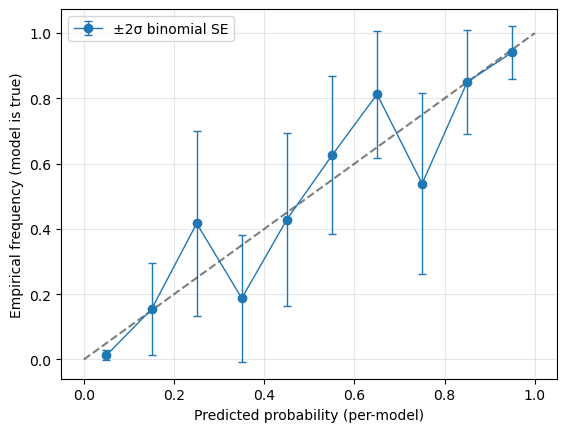

In [11]:
k = np.asarray(correct_model, dtype=float)
n = np.asarray(total_entries, dtype=float)
p_hat = np.divide(k, n, out=np.full_like(n, np.nan, dtype=float), where=n>0)

# Standard error
std = np.sqrt(p_hat * (1 - p_hat) / n)

# Plot with error bars = ±2σ
mask = n > 0
plt.figure()
plt.errorbar(bin_centers[mask], p_hat[mask], yerr=2*std[mask],
             fmt='-o', capsize=3, lw=1, label='±2σ binomial SE')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('Predicted probability (per-model)')
plt.ylabel('Empirical frequency (model is true)')

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()